# Bratu Continuation Demo

This notebook provides a demonstration of solving the 1D Bratu boundary value problem using finite differences and a pseudo-arclength continuation method. The goal is to trace the solution branch, particularly through the fold bifurcation that occurs near $\lambda \approx 3.5138$.

The Bratu problem is given by:
$$u'' + \lambda e^{u} = 0, \quad u(0)=u(1)=0$$

### Outline:
- Discretize the domain with Dirichlet boundary conditions.
- Assemble the residual and Jacobian for the discretized system.
- Implement a damped Newton's method for the corrector step.
- Use a pseudo-arclength predictor-corrector scheme to trace the solution branch.
- Visualize the bifurcation diagram (max $u$ vs. $\lambda$) and selected solution profiles.

### Section 1–2: Parameters, Grid, and Operators
We start by defining the simulation parameters, setting up the spatial grid, and constructing the finite difference approximation of the Laplacian operator with Dirichlet boundary conditions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (7, 5), "axes.grid": True})

# Continuation start
lam_start = 0.05

# Discretization
n = 400  # interior points
x = np.linspace(0.0, 1.0, n + 2)  # includes boundaries
h = x[1] - x[0]

# Dirichlet Laplacian (interior block)
diag = -2.0 * np.ones(n) / h**2
off = 1.0 * np.ones(n - 1) / h**2
L = np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)

def l2_norm(v):
    return np.sqrt(np.mean(v**2))

### Section 3: Residual and Jacobian for Bratu Problem
For the Newton's method solver, we need to define the residual of the discretized Bratu equation, $R(u, \lambda) = L u + \lambda e^u$, and its Jacobian matrix, $J(u, \lambda) = L + \lambda \text{diag}(e^u)$.

In [2]:
def residual(u, lam):
    return L @ u + lam * np.exp(u)

def jacobian(u, lam):
    return L + lam * np.diag(np.exp(u))

### Section 4: Damped Newton Solver
A damped Newton's method with a backtracking line search is implemented to solve the nonlinear system $R(u, \lambda) = 0$. The line search improves the robustness of the solver.

In [3]:
def newton_solve(u0, lam, tol=1e-10, max_iter=25, ls_beta=0.5, ls_c=1e-4):
    u = u0.copy()
    res = residual(u, lam)
    res_norm = np.linalg.norm(res, ord=np.inf)
    history = [res_norm]

    for k in range(max_iter):
        if res_norm < tol:
            return u, True, history

        J = jacobian(u, lam)
        try:
            du = np.linalg.solve(J, -res)
        except np.linalg.LinAlgError:
            return u, False, history

        step = 1.0
        accepted = False
        while step > 1e-6:
            u_trial = u + step * du
            res_trial = residual(u_trial, lam)
            res_trial_norm = np.linalg.norm(res_trial, ord=np.inf)
            if res_trial_norm <= (1 - ls_c * step) * res_norm:
                u, res, res_norm = u_trial, res_trial, res_trial_norm
                history.append(res_norm)
                accepted = True
                break
            step *= ls_beta

        if not accepted:
            return u, False, history

    return u, res_norm < tol, history

### Section 5: Pseudo-arclength Continuation
This is the main part of the notebook. The `pseudo_arclength_continuation` function implements a predictor-corrector scheme where the step size is controlled by an arclength parameter `ds`. This allows the method to gracefully handle the turning point in the Bratu curve.

In [4]:
def pseudo_arclength_continuation(
    lam0=lam_start,
    lam1=0.25,
    ds=0.12,
    max_steps=180,
    tol=1e-9,
    max_newton=14,
):
    """Follow the Bratu branch through the turning point using pseudo-arclength."""

    solutions = []
    lambdas = []
    newton_iters = []
    max_u = []

    # First solution
    u0_guess = np.zeros(n)
    u0, ok0, hist0 = newton_solve(u0_guess, lam0, tol=tol)
    if not ok0:
        raise RuntimeError("Failed to converge initial Bratu solve for pseudo-arclength")
    solutions.append(u0)
    lambdas.append(lam0)
    newton_iters.append(len(hist0) - 1)
    max_u.append(np.max(u0))

    # Second solution (provides initial tangent)
    u1, ok1, hist1 = newton_solve(u0, lam1, tol=tol)
    if not ok1:
        raise RuntimeError("Failed to converge second Bratu solve for pseudo-arclength")
    solutions.append(u1)
    lambdas.append(lam1)
    newton_iters.append(len(hist1) - 1)
    max_u.append(np.max(u1))

    for _ in range(2, max_steps + 1):
        sec_u = solutions[-1] - solutions[-2]
        sec_lam = lambdas[-1] - lambdas[-2]
        ds_sec = np.sqrt(np.linalg.norm(sec_u) ** 2 + sec_lam**2)
        if ds_sec < 1e-12:
            break

        tu = sec_u / ds_sec
        tlam = sec_lam / ds_sec

        u_pred = solutions[-1] + ds * tu
        lam_pred = lambdas[-1] + ds * tlam

        u = u_pred.copy()
        lam = lam_pred
        success = False
        for k in range(max_newton):
            res = residual(u, lam)
            constr = tu @ (u - u_pred) + tlam * (lam - lam_pred)
            res_norm = np.linalg.norm(res, ord=np.inf)
            if max(res_norm, abs(constr)) < tol:
                success = True
                break

            J = jacobian(u, lam)
            aug = np.block(
                [
                    [J, np.exp(u).reshape(-1, 1)],
                    [tu.reshape(1, -1), np.array([[tlam]])],
                ]
            )
            rhs = -np.hstack([res, constr])

            try:
                sol = np.linalg.solve(aug, rhs)
            except np.linalg.LinAlgError:
                break

            du = sol[:-1]
            dlam = sol[-1]
            u += du
            lam += dlam

        if not success:
            break

        solutions.append(u)
        lambdas.append(lam)
        newton_iters.append(k + 1)
        max_u.append(np.max(u))

    return {
        "lambda": np.array(lambdas),
        "solutions": solutions,
        "newton_iters": np.array(newton_iters),
        "max_u": np.array(max_u),
    }

### Section 6: Run Pseudo-arclength Continuation

In [5]:
cont_arc = pseudo_arclength_continuation(
    lam0=lam_start,
    lam1=0.25,
    ds=0.12,
    max_steps=1000,
    tol=1e-9,
    max_newton=16,
)
print(
    f"Arc-length points: {len(cont_arc['lambda'])}, "
    f"lambda range = [{cont_arc['lambda'].min():.4f}, {cont_arc['lambda'].max():.4f}]"
)
print(
    f"Newton iterations per step: min {cont_arc['newton_iters'].min()}, "
    f"max {cont_arc['newton_iters'].max()}"
)

Arc-length points: 1001, lambda range = [0.0198, 3.5138]
Newton iterations per step: min 2, max 6


### Section 7: Visualize Continuation Branch and Profiles
The results of the continuation are visualized by plotting the bifurcation diagram (max of $u$ versus $\lambda$) and the solution profiles at selected points along the branch.

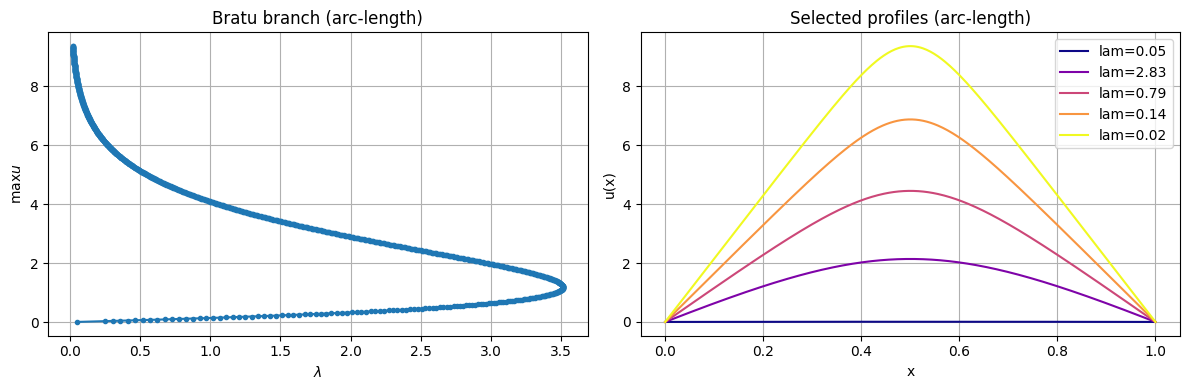

In [6]:
lams = cont_arc["lambda"]
branch = cont_arc["max_u"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(lams, branch, marker="o", ms=3)
axes[0].set_xlabel(r"$\lambda$")
axes[0].set_ylabel(r"$\max u$")
axes[0].set_title("Bratu branch (arc-length)")

# pick a few representative points along the arc-length branch
pick_idx = np.linspace(0, len(lams) - 1, 5, dtype=int)
colors = plt.cm.plasma(np.linspace(0, 1, len(pick_idx)))
x_int = x[1:-1]
for idx, c in zip(pick_idx, colors):
    u_int = cont_arc["solutions"][idx]
    u_full = np.concatenate(([0.0], u_int, [0.0]))
    axes[1].plot(x, u_full, color=c, label=f"lam={lams[idx]:.2f}")

axes[1].set_xlabel("x")
axes[1].set_ylabel("u(x)")
axes[1].set_title("Selected profiles (arc-length)")
axes[1].legend()
plt.tight_layout()
plt.show()

### Section 8: Validate Residuals and Step Control
A final check of the residual norm at the last computed point of the branch to ensure that the solutions are accurate.

In [7]:
final_u = cont_arc["solutions"][-1]
final_lam = cont_arc["lambda"][-1]
res_inf = np.linalg.norm(residual(final_u, final_lam), ord=np.inf)
print(f"Final residual inf-norm at lambda={final_lam:.4f}: {res_inf:.2e}")
print(f"Arc-length points traced: {len(cont_arc['lambda'])}")
print("Note: arc-length continuation lets us step through the turning point near lambda ≈ 3.5138.")

Final residual inf-norm at lambda=0.0198: 8.70e-10
Arc-length points traced: 1001
Note: arc-length continuation lets us step through the turning point near lambda ≈ 3.5138.
